In [ ]:
!pip install pycaret

In [ ]:
!pip install lime

In [ ]:
!pip install shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_1samp, shapiro
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import recall_score, make_scorer, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from graphviz import Source
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import SVG, display
import shap

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ml1_final_project/data_cardiovascular_risk.csv')

In [ ]:
columns_to_convert = ['sex', 'education', 'is_smoking', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'TenYearCHD']
df[columns_to_convert] = df[columns_to_convert].astype('object')

In [ ]:
categorical_columns = df.select_dtypes(include='object').columns
numerical_columns = df.select_dtypes(include=['float', 'int']).columns

In [ ]:

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Remove rows where 'bpmeds' column is null
df = df.dropna(subset=['BPMeds'])

imputing_median1 = df[df['is_smoking'] == 'YES']['cigsPerDay'].median()
df['cigsPerDay'] = df['cigsPerDay'].fillna(imputing_median1)

df.drop('id', axis=1, inplace=True)
df.drop('education', axis=1, inplace=True)
df.drop(['is_smoking', 'prevalentStroke'], axis=1, inplace=True)

for var in ['totChol', 'BMI', 'heartRate']:
  imputer = IterativeImputer(random_state=0)
  df[[var]] = imputer.fit_transform(df[[var]])


# fit and transform the imputer on your data
imputer = IterativeImputer(random_state = 0)
imputer.fit(df[['glucose']])

df[['glucose']] = imputer.transform(df[['glucose']])


In [ ]:
df.isnull().sum()

age             0
sex             0
cigsPerDay      0
BPMeds          0
prevalentHyp    0
diabetes        0
totChol         0
sysBP           0
diaBP           0
BMI             0
heartRate       0
glucose         0
TenYearCHD      0
dtype: int64

In [ ]:
df = pd.get_dummies(df, drop_first=True)

In [ ]:
X = df.drop(['TenYearCHD_1'], axis = 1)
y = df['TenYearCHD_1']

In [ ]:
X_winsorized = X.copy()

In [ ]:
from scipy.stats.mstats import winsorize
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score

# Define the range of winsorizing limits to try
lower_limits_range = [0, 0.01, 0.05, 0.1, 0.15, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
upper_limits_range = [0, 0.01, 0.05, 0.1, 0.15, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

# Initialize variables to store the optimal limits and corresponding AUC score
optimal_limits = {}
optimal_auc = 0

# Iterate over the columns
for column in X.columns:
    # Initialize variables to store the optimal lower and upper limits for the current column
    optimal_lower_limit = 0
    optimal_upper_limit = 0
    
    # Iterate over the lower limits range
    for lower_limit in lower_limits_range:
        # Iterate over the upper limits range
        for upper_limit in upper_limits_range:
            # Apply winsorizing on the column with the current lower and upper limits
            X_winsorized = X.copy()
            X_winsorized[column] = winsorize(X_winsorized[column], limits=(lower_limit, upper_limit))
        
            # Split the winsorized data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X_winsorized, y, test_size=0.2, random_state=42)
        
            # Train Gaussian Naive Bayes
            gnb = GaussianNB()
            gnb.fit(X_train, y_train)
        
            # Make predictions and calculate AUC
            y_pred = gnb.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_pred)
        
            # Check if the current AUC is higher than the optimal AUC
            if auc > optimal_auc:
                optimal_auc = auc
                optimal_lower_limit = lower_limit
                optimal_upper_limit = upper_limit
    
    # Store the optimal limits for the current column
    optimal_limits[column] = (optimal_lower_limit, optimal_upper_limit)

# Print the optimal limits for each column
for column, (lower_limit, upper_limit) in optimal_limits.items():
    print(f"Optimal limits for column '{column}': Lower Limit = {lower_limit}, Upper Limit = {upper_limit}")

# Print the overall optimal AUC score
print("Optimal AUC:", optimal_auc)


Optimal limits for column 'age': Lower Limit = 0, Upper Limit = 0
Optimal limits for column 'cigsPerDay': Lower Limit = 0.7, Upper Limit = 0.01
Optimal limits for column 'totChol': Lower Limit = 0, Upper Limit = 0
Optimal limits for column 'sysBP': Lower Limit = 0, Upper Limit = 0
Optimal limits for column 'diaBP': Lower Limit = 0.8, Upper Limit = 0
Optimal limits for column 'BMI': Lower Limit = 0, Upper Limit = 0
Optimal limits for column 'heartRate': Lower Limit = 0, Upper Limit = 0
Optimal limits for column 'glucose': Lower Limit = 0.7, Upper Limit = 0.2
Optimal limits for column 'sex_M': Lower Limit = 0, Upper Limit = 0
Optimal limits for column 'BPMeds_1.0': Lower Limit = 0, Upper Limit = 0
Optimal limits for column 'prevalentHyp_1': Lower Limit = 0, Upper Limit = 0.4
Optimal limits for column 'diabetes_1': Lower Limit = 0, Upper Limit = 0
Optimal AUC: 0.7270663615560642


### Optimal winsorize on NB

In [ ]:
df = pd.get_dummies(df, drop_first=True)
X = df.drop(['TenYearCHD_1'], axis = 1)
y = df['TenYearCHD_1']

# Apply winsorization to each column with the optimal limits
X_winsorized = X.copy()

X_winsorized['age'] = winsorize(X_winsorized['age'], limits=(0, 0))
X_winsorized['cigsPerDay'] = winsorize(X_winsorized['cigsPerDay'], limits=(0.7, 0.01))
X_winsorized['totChol'] = winsorize(X_winsorized['totChol'], limits=(0, 0))
X_winsorized['sysBP'] = winsorize(X_winsorized['sysBP'], limits=(0, 0))
X_winsorized['diaBP'] = winsorize(X_winsorized['diaBP'], limits=(0.8, 0))
X_winsorized['BMI'] = winsorize(X_winsorized['BMI'], limits=(0, 0))
X_winsorized['heartRate'] = winsorize(X_winsorized['heartRate'], limits=(0, 0))
X_winsorized['glucose'] = winsorize(X_winsorized['glucose'], limits=(0.7, 0.2))
X_winsorized['sex_M'] = winsorize(X_winsorized['sex_M'], limits=(0, 0))
X_winsorized['BPMeds_1.0'] = winsorize(X_winsorized['BPMeds_1.0'], limits=(0, 0))
X_winsorized['prevalentHyp_1'] = winsorize(X_winsorized['prevalentHyp_1'], limits=(0, 0.4))
X_winsorized['diabetes_1'] = winsorize(X_winsorized['diabetes_1'], limits=(0, 0))

# Split the winsorized data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_winsorized, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Train Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train_s, y_train)

# Make predictions and calculate AUC
y_pred = gnb.predict_proba(X_test_s)[:, 1]
auc = roc_auc_score(y_test, y_pred)

# Print the AUC score
print("AUC:", auc)


AUC: 0.7453729977116705


In [ ]:
X_train

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose,sex_M,BPMeds_1.0,prevalentHyp_1,diabetes_1
2304,55,15.0,280.0,144.0,92.0,19.50,79.0,84.0,0,0,0,0
952,59,15.0,167.0,156.0,104.0,15.96,72.0,84.0,0,0,0,0
1976,40,20.0,271.0,138.5,92.0,27.24,80.0,84.0,0,0,0,0
3305,58,20.0,255.0,146.0,92.0,27.47,75.0,84.0,1,0,0,0
1530,50,15.0,305.0,151.0,106.5,25.38,100.0,84.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1109,43,15.0,185.0,125.0,92.0,23.18,75.0,84.0,0,0,0,0
1144,44,20.0,225.0,128.0,92.0,26.79,82.0,85.0,1,0,0,0
1310,60,15.0,259.0,155.0,92.0,27.94,68.0,88.0,0,0,0,0
870,58,15.0,279.0,181.0,92.0,22.49,66.0,84.0,1,0,0,0


### Smote + Optimal winsorize

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the winsorized dataset
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_winsorized, y)

# Split the SMOTE data into training and testing sets
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

# Train Gaussian Naive Bayes on the SMOTE data
gnb_smote = GaussianNB()
gnb_smote.fit(X_train_smote, y_train_smote)

# Make predictions on the test set and calculate AUC
y_pred_smote = gnb_smote.predict_proba(X_test_smote)[:, 1]
auc_smote = roc_auc_score(y_test_smote, y_pred_smote)

# Print the AUC score
print("AUC (with SMOTE):", auc_smote)

AUC (with SMOTE): 0.7061843807533463


In [ ]:
type(y_smote)

pandas.core.series.Series

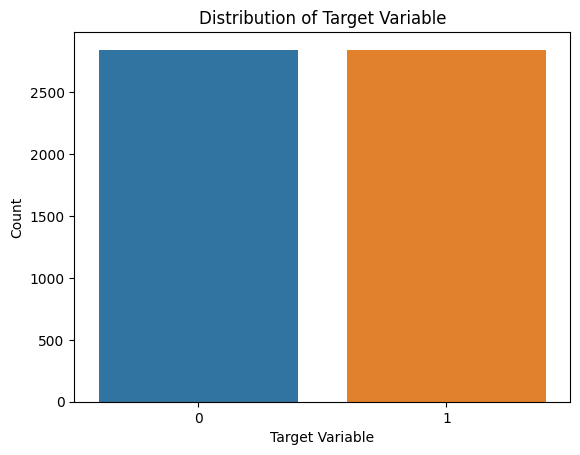

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of y_smote
sns.countplot(data=y_smote, x=y_smote)

# Set the plot title and labels
plt.title('Distribution of Target Variable')
plt.xlabel('Target Variable')
plt.ylabel('Count')

# Show the plot
plt.show()


In [ ]:
y_smote.value_counts()

1    2842
0    2842
Name: TenYearCHD_1, dtype: int64

In [ ]:
y_smote

0       1
1       0
2       0
3       1
4       0
       ..
5679    1
5680    1
5681    1
5682    1
5683    1
Name: TenYearCHD_1, Length: 5684, dtype: uint8

### Apply MinMaxScaler + Optimal Winsorize

In [ ]:
# Apply winsorization to each column with the optimal limits
X_winsorized = X.copy()

X_winsorized['age'] = winsorize(X_winsorized['age'], limits=(0, 0))
X_winsorized['cigsPerDay'] = winsorize(X_winsorized['cigsPerDay'], limits=(0.7, 0.01))
X_winsorized['totChol'] = winsorize(X_winsorized['totChol'], limits=(0, 0))
X_winsorized['sysBP'] = winsorize(X_winsorized['sysBP'], limits=(0, 0))
X_winsorized['diaBP'] = winsorize(X_winsorized['diaBP'], limits=(0.8, 0))
X_winsorized['BMI'] = winsorize(X_winsorized['BMI'], limits=(0, 0))
X_winsorized['heartRate'] = winsorize(X_winsorized['heartRate'], limits=(0, 0))
X_winsorized['glucose'] = winsorize(X_winsorized['glucose'], limits=(0.7, 0.2))
X_winsorized['sex_M'] = winsorize(X_winsorized['sex_M'], limits=(0, 0))
X_winsorized['BPMeds_1.0'] = winsorize(X_winsorized['BPMeds_1.0'], limits=(0, 0))
X_winsorized['prevalentHyp_1'] = winsorize(X_winsorized['prevalentHyp_1'], limits=(0, 0.4))
X_winsorized['diabetes_1'] = winsorize(X_winsorized['diabetes_1'], limits=(0, 0))

# Split the winsorized data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_winsorized, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Train Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Make predictions and calculate AUC
y_pred = gnb.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)

# Print the AUC score
print("AUC:", auc)


AUC: 0.7250892448512586


#### Optimal Winsorize + Minmax + Smote

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply winsorization to each column with the optimal limits
X_winsorized = X.copy()

X_winsorized['age'] = winsorize(X_winsorized['age'], limits=(0, 0))
X_winsorized['cigsPerDay'] = winsorize(X_winsorized['cigsPerDay'], limits=(0.7, 0.01))
X_winsorized['totChol'] = winsorize(X_winsorized['totChol'], limits=(0, 0))
X_winsorized['sysBP'] = winsorize(X_winsorized['sysBP'], limits=(0, 0))
X_winsorized['diaBP'] = winsorize(X_winsorized['diaBP'], limits=(0.8, 0))
X_winsorized['BMI'] = winsorize(X_winsorized['BMI'], limits=(0, 0))
X_winsorized['heartRate'] = winsorize(X_winsorized['heartRate'], limits=(0, 0))
X_winsorized['glucose'] = winsorize(X_winsorized['glucose'], limits=(0.7, 0.2))
X_winsorized['sex_M'] = winsorize(X_winsorized['sex_M'], limits=(0, 0))
X_winsorized['BPMeds_1.0'] = winsorize(X_winsorized['BPMeds_1.0'], limits=(0, 0))
X_winsorized['prevalentHyp_1'] = winsorize(X_winsorized['prevalentHyp_1'], limits=(0, 0.4))
X_winsorized['diabetes_1'] = winsorize(X_winsorized['diabetes_1'], limits=(0, 0))

# Apply SMOTE to the winsorized dataset
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_winsorized, y)

# Split the SMOTE data into training and testing sets
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_test_smote = scaler.transform(X_test_smote)

# Train Gaussian Naive Bayes on the SMOTE data
gnb_smote = GaussianNB()
gnb_smote.fit(X_train_smote, y_train_smote)

# Make predictions on the test set and calculate AUC
y_pred_smote = gnb_smote.predict_proba(X_test_smote)[:, 1]
auc_smote = roc_auc_score(y_test_smote, y_pred_smote)

# Print the AUC score
print("AUC (with SMOTE):", auc_smote)

AUC (with SMOTE): 0.7061812708364432
